# Import Required Repositories

In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import string
import scipy
# from datetime import datatime
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, multilabel_confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
import seaborn as sns
from itertools import cycle

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

     |████████████████████████████████| 880 kB 9.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=ef03e93ad9a6f0279f59d92746136b7e3182a064a10462b207d74fb1a9ce5ad2
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


# Movie Data Loading

In [4]:
# Set data directory
DRIVE_ROOT = '/content/drive'
DATA_DIRECTORY = '/My Drive/CS-UA480/Data'

In [5]:
# Get data from google drive
from google.colab import drive
drive.mount(DRIVE_ROOT) 

Mounted at /content/drive


In [6]:
# Load preprocessed train/test/val data
train = pd.read_csv(DRIVE_ROOT+DATA_DIRECTORY+'/train.csv', delimiter=',')
test = pd.read_csv(DRIVE_ROOT+DATA_DIRECTORY+'/test.csv', delimiter=',')
val = pd.read_csv(DRIVE_ROOT+DATA_DIRECTORY+'/val.csv', delimiter=',')

In [7]:
train

,title,overview,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Night Moves,"When Los Angeles private detective, Harry Mose...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,loudQUIETloud: A Film About the Pixies,When college rock darlings the Pixies broke up...,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Holy Flame of the Martial World,This internationally popular tale of a brother...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dead Souls,"On his 18th birthday, Johnny finds out that he...",0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Sinister,Found footage helps a true-crime novelist real...,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21307,Christmas on Mars,The film tells the story of the experiences of...,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
21308,Programming The Nation?,Programming the Nation? takes an encompassing ...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21309,Labyrinth,Frustrated with babysitting on yet another wee...,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
21310,Paradise Lost 3: Purgatory,A further investigation into the arrest of thr...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
attributes = list(train.columns[2:])

## **Download and Load GloVe Embeddings**

We use GloVe embedding parameters to initialize our layer of word representations.

In [9]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2022-05-05 02:07:07--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 74.125.197.100, 74.125.197.113, 74.125.197.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/73rgm0kp4dicehe3jmtrbncbaj08sjkf/1651716375000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2022-05-05 02:07:08--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/73rgm0kp4dicehe3jmtrbncbaj08sjkf/1651716375000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|74.125.142.132|:443

In [10]:
# Define Function for storing and loading our embedding
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

In [11]:
embeddings.shape

(50002, 300)

# Tokenize and Stopword Removal overview

In [12]:
def tokenize_stopword_remove(data, labels, tokenizer, vocab, max_seq_length=1000):
    # Load all stopwords and puncuation
    stopwords_punct = set(stopwords.words('english')+list(string.punctuation))
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm(data):
        tokenized = tokenizer.tokenize(ex.lower())
        tokenized_stopword_free = [token for token in tokenized if token not in stopwords_punct]
        ids = [vocab_to_idx.get(token, 1) for token in tokenized_stopword_free]
        text_data.append(ids)
    return text_data, labels

# Using preload GLoVe Embedding to tokenize
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = tokenize_stopword_remove(train['overview'].to_numpy(), train.iloc[:, 2:].to_numpy(), tokenizer, vocab)
val_data_indices, val_labels = tokenize_stopword_remove(val['overview'].to_numpy(), val.iloc[:,2:].to_numpy(), tokenizer, vocab)
test_data_indices, test_labels = tokenize_stopword_remove(test['overview'].to_numpy(), test.iloc[:,2:].to_numpy(), tokenizer, vocab)

  0%|          | 0/21312 [00:00<?, ?it/s]

  0%|          | 0/4567 [00:00<?, ?it/s]

  0%|          | 0/4568 [00:00<?, ?it/s]

In [13]:
# print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train labels first 5 examples:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0]]


In [14]:
# To see the average length
length_list = []
for foo in train_data_indices:
  length_list.append(len(foo))
print(np.mean(length_list))

31.78584834834835


(array([3803., 6117., 4420., 3474., 1451.,  962.,  580.,  356.,  133.,
          16.]),
 array([  2. ,  13.8,  25.6,  37.4,  49.2,  61. ,  72.8,  84.6,  96.4,
        108.2, 120. ]),
 <a list of 10 Patch objects>)

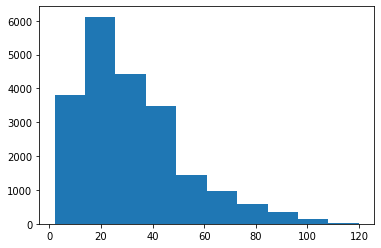

In [15]:
plt.hist(length_list)

## Create DataLoaders

In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset

class MovieDataset(Dataset):
    
    def __init__(self, data_list, target_list, max_sent_length=1280):
 
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
 
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def spam_collate_func(self,batch):

        data_list = [] # store padded sequences
        label_list = []
        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length


        # Add current sentence's label to the label_list
        label_list = [datum[1] for datum in batch]

        # Find the length of the longest sequence in the batch
        max_batch_seq_len = max(len(datum[0]) for datum in batch)
        if max_batch_seq_len > self.max_sent_length:
            max_batch_seq_len = self.max_sent_length

        for datum in batch:
            padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_batch_seq_len-len(datum[0]))), 
                                mode="constant", constant_values=0)
            data_list.append(padded_vec)

        # Change the list to torch
        data_list = torch.from_numpy(np.array(data_list))
        label_list = torch.LongTensor(label_list)

        return [data_list, label_list]


BATCH_SIZE = 64
max_sent_length= 1000
# Create the train/val/test dataloader for pytorch training
train_dataset = MovieDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = MovieDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = MovieDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)


In [17]:
# Check our dataloader
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("label dimension: ",labels.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data_batch, labels = next(iter(val_loader))
print("data batch dimension: ", data_batch.size())
print("label dimension: ",labels.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 101])
label dimension:  torch.Size([64, 20])
data_batch:  tensor([[ 3368,  1751,  2644,  ...,     0,     0,     0],
        [26229,   309, 18971,  ...,     0,     0,     0],
        [ 5269, 14918,  5083,  ...,     0,     0,     0],
        ...,
        [ 9450,   597,   412,  ...,     0,     0,     0],
        [  742,     1, 20829,  ...,     0,     0,     0],
        [10544,   216,   664,  ...,     0,     0,     0]])
labels:  tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
data batch dimension:  torch.Size([64, 96])
label dimension:  torch.Size([64, 20])
data_batch:  tensor([[  867,  9129, 48484,  ...,     0,     0,     0],
        [ 1672,  1062,     1,  ...,     0,     0,     0],
        [    1,     1,  3816,  ...,     0,     0,     0],
        ...,
        [41437,  6651,   702,  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


# BiLSTM Model

In [18]:
# Import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create our LSTM Classifier class
class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p = dropout_prob)
        self.lstm = nn.LSTM(embeddings.shape[1], hidden_size, num_layers, batch_first=True, 
                            bidirectional=True, dropout=0.3)
        # self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.clf = nn.Linear(hidden_size*2, num_classes)
    
    def load_pretrained_embeddings(self, embeddings):

        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer

    # Create forward function
    def forward(self, inputs):
        # Embedding
        out = self.dropout(self.embedding_layer(inputs))
        # BiLSTM
        out, _ = self.lstm(out, None)
        # Max pooling
        out = out.max(1)[0]
        # Classifier
        out = self.clf(out)
        # Apply Activation
        logits = self.sigmoid(out)
        
        return logits

# CNN Model

In [19]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, embeddings, num_classes, num_filters=[100,100,100], filter_sizes=[3,4,5],  dropout_prob=0.3):
        super().__init__()
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.dropout = nn.Dropout(p = dropout_prob)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=embeddings.shape[1],
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        self.sigmoid = nn.Sigmoid()
        self.clf = nn.Linear(sum(num_filters), num_classes)
    
    def load_pretrained_embeddings(self, embeddings):

        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer

    # create forward function for our model
    def forward(self, inputs):
        # Embedding
        out = self.dropout(self.embedding_layer(inputs)).float()
        out = out.permute(0,2,1)
        # CNN
        x_conv_list = [F.relu(conv1d(out)) for conv1d in self.conv1d_list]
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in x_conv_list]
        out =  torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list], dim=1)
        # Classifier
        out = self.clf(out)
        # Apply Activation
        logits = self.sigmoid(self.dropout(out))
        
        return logits

# Training Evaluation

In [20]:
# Create our evaluation metrics for training
def evaluate(model, dataloader, device):

    epoch_pred = None
    epoch_labels = None
    model.eval()
    with torch.no_grad():
        for (data_batch, batch_labels) in dataloader:
            out = model(data_batch.to(device))
            if epoch_pred is None and epoch_labels is None:
              epoch_pred = out
              epoch_labels = batch_labels.to(device)
            else:
              epoch_pred = torch.cat((epoch_pred, out), 0)
              epoch_labels = torch.cat((epoch_labels, batch_labels.to(device)), 0)
    epoch_pred = epoch_pred.cpu().numpy()
    epoch_labels = epoch_labels.cpu().numpy().astype(int)
    return roc_auc_score(epoch_labels, epoch_pred, average='micro')

In [21]:
# Create our evaluation metrics for training
def evaluate_display(model, dataloader, device, attributes, model_name):
  
    epoch_pred = None
    epoch_labels = None
    model.eval()
    with torch.no_grad():
        for (data_batch, batch_labels) in dataloader:
            out = model(data_batch.to(device))
            if epoch_pred is None and epoch_labels is None:
              epoch_pred = out
              epoch_labels = batch_labels.to(device)
            else:
              epoch_pred = torch.cat((epoch_pred, out), 0)
              epoch_labels = torch.cat((epoch_labels, batch_labels.to(device)), 0)
    epoch_pred = epoch_pred.cpu().numpy()
    epoch_labels = epoch_labels.cpu().numpy().astype(int)
    y_pred = (epoch_pred > 0.25).astype(int)
    print("AUC score: ", roc_auc_score(epoch_labels, epoch_pred, average='micro'))
    print("Micro F1 score: ", f1_score(epoch_labels, y_pred, average='micro'))
    print("Micro Recall score: ", recall_score(epoch_labels, y_pred, average='micro'))
    print("Micro Precision score: ", precision_score(epoch_labels, y_pred, average='micro'))
    print("Accuracy score: ", accuracy_score(epoch_labels, y_pred))
    
    display_performance(epoch_labels, y_pred, attributes)
    display_confusion_matrix(epoch_labels, y_pred, attributes)
    plot_roc_auc_graph(epoch_labels, epoch_pred, attributes, model_name)

In [35]:
# Initialize our BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 20
bidirectional=True
torch.manual_seed(1234)
N_FILTERS = 100
FILTER_SIZES = [3,4,5]

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

# Create our model: LSTM or CNN
model_name = "CNN"
if model_name == "BiLSTM":
  model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, True)
elif model_name == "CNN":
  model = CNNClassifier(embeddings, num_classes)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Training Process

In [36]:
# The actual training process
# We trained for 50 epoches
# Early stop to prevent overfitting
# Stop when 5 continued epochs does not improve performance

train_loss_history = []
val_f1_history = []
best_val_f1 = 0
n_no_improve = 0
early_stop_patience=5
NUM_EPOCHS=50

#start_time = datetime.now()
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device))
        optimizer.zero_grad()
        loss = criterion(preds.float(), batch_labels.to(device).float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_history.append(loss.item())
        
    # The end of a training epoch 
    curr_val_f1 = evaluate(model, val_loader, device=device)
    val_f1_history.append(curr_val_f1)
    print("epoch: {}, val_roc_auc: {}".format(epoch+1, curr_val_f1))
    if curr_val_f1 > best_val_f1:
        best_val_f1 = curr_val_f1
        torch.save(model, 'best_model.pt')
        n_no_improve = 0
    else:
        n_no_improve += 1 
    if n_no_improve > early_stop_patience:
        print("Early stopped at epoch ",epoch)
        break

print("Best validation roc_auc is: ", best_val_f1)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 1, val_roc_auc: 0.8512098353383302
epoch: 2, val_roc_auc: 0.8532879906317308
epoch: 3, val_roc_auc: 0.8427619615211887
epoch: 4, val_roc_auc: 0.8281151828843873
epoch: 5, val_roc_auc: 0.827694699280352
epoch: 6, val_roc_auc: 0.8167209589132489
epoch: 7, val_roc_auc: 0.8153374258519618
epoch: 8, val_roc_auc: 0.8135721225034629
Early stopped at epoch  7
Best validation roc_auc is:  0.8532879906317308


# Evaluate our best model on the Test set

In [37]:
model = torch.load('best_model.pt')
result = evaluate(model, test_loader, device)
print("ROC-AUC score on the test set: {:.3f}".format(result))

ROC-AUC score on the test set: 0.849


In [25]:
# Define our recall metric
def macro_label_based_recall(y, y_pred, detailed=False):
  # Calculate Averaged Macro Recall
  # Calculate TP along columns
  true_positive = np.sum(np.logical_and(y, y_pred), axis = 0).astype('float64')

  # Calculate TP + FN along columns
  true_positive_false_negative = np.sum(y, axis = 0).astype('float64')

  # Calculate Recall
  recall = np.divide(true_positive, true_positive_false_negative, out=np.zeros_like(true_positive), where=true_positive_false_negative!=0)
  if detailed:
    return recall
  else:
    return np.mean(recall)

In [26]:
# Define our precision metric
def macro_label_based_precision(y, y_pred, detailed=False):
  # Calculate Averaged Macro Precision
  # Calculate TP along columns
  true_positive = np.sum(np.logical_and(y, y_pred), axis = 0).astype('float64')
  # Calculate TP + FP along columns
  true_positive_false_positive = np.sum(y_pred, axis = 0).astype('float64')
  # Calculate Precision
  precision = np.divide(true_positive, true_positive_false_positive, out=np.zeros_like(true_positive), where=true_positive_false_positive!=0)
  if detailed:
    return precision
  else:
    return np.mean(precision)

In [27]:
# Show the genre-level performance of our model
def display_performance(y, y_pred, attributes):
  curr_precision = macro_label_based_precision(y, y_pred, True)
  curr_recall = macro_label_based_recall(y, y_pred, True)
  for i in range(len(attributes)):
    print(attributes[i]+": Precision: %f, Recall: %f" % (curr_precision[i], curr_recall[i]))

In [28]:
# Display the genre-level confusion matrix for error analysis
def display_confusion_matrix(y, y_pred, attributes):
  confusion_matrixes = multilabel_confusion_matrix(y, y_pred)
  fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25,18))
  for i in range(len(confusion_matrixes)):
    cm = confusion_matrixes[i]
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [value for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape((2,2))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes.ravel()[i])
    axes.ravel()[i].set_title('Confusion matrix of %s'%attributes[i])

In [29]:
# Display ROC-AUC Graphs
def plot_roc_auc_graph(y, y_score, attributes, model_name):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(attributes)):
      fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  lw=2
  plt.figure(figsize=(20,15))
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color="deeppink",
      linestyle=":",
      linewidth=4,
  )
  
  cmap = plt.get_cmap('gist_rainbow')
  colors = [cmap(i) for i in np.linspace(0, 1, len(attributes))]
  for i in range(len(attributes)):
      plt.plot(
          fpr[i],
          tpr[i],
          lw=lw,
          color=colors[i],
          label="ROC curve of class {0} (area = {1:0.2f})".format(attributes[i], roc_auc[i]),
      )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC-AUC Graph of Glove + "+model_name)
  plt.legend(loc="lower right")
  plt.show()

AUC score:  0.8511841984700407
Micro F1 score:  0.48349022447501805
Micro Recall score:  0.6851718830169318
Micro Precision score:  0.37353846153846154
Accuracy score:  0.04553415061295972
Action: Precision: 0.368966, Recall: 0.618497
Adventure: Precision: 0.250996, Recall: 0.493473
Animation: Precision: 0.336788, Recall: 0.393939
Comedy: Precision: 0.457381, Recall: 0.760409
Crime: Precision: 0.249771, Recall: 0.579618
Documentary: Precision: 0.590832, Recall: 0.682353
Drama: Precision: 0.466281, Recall: 0.974333
Family: Precision: 0.241379, Recall: 0.509091
Fantasy: Precision: 0.265560, Recall: 0.294931
Foreign: Precision: 0.040000, Recall: 0.041237
History: Precision: 0.186441, Recall: 0.083969
Horror: Precision: 0.337914, Recall: 0.751799
Music: Precision: 0.464286, Recall: 0.492891
Mystery: Precision: 0.158621, Recall: 0.424354
Romance: Precision: 0.302902, Recall: 0.687243
Science Fiction: Precision: 0.412863, Recall: 0.545205
TV Movie: Precision: 0.105263, Recall: 0.021505
Thril

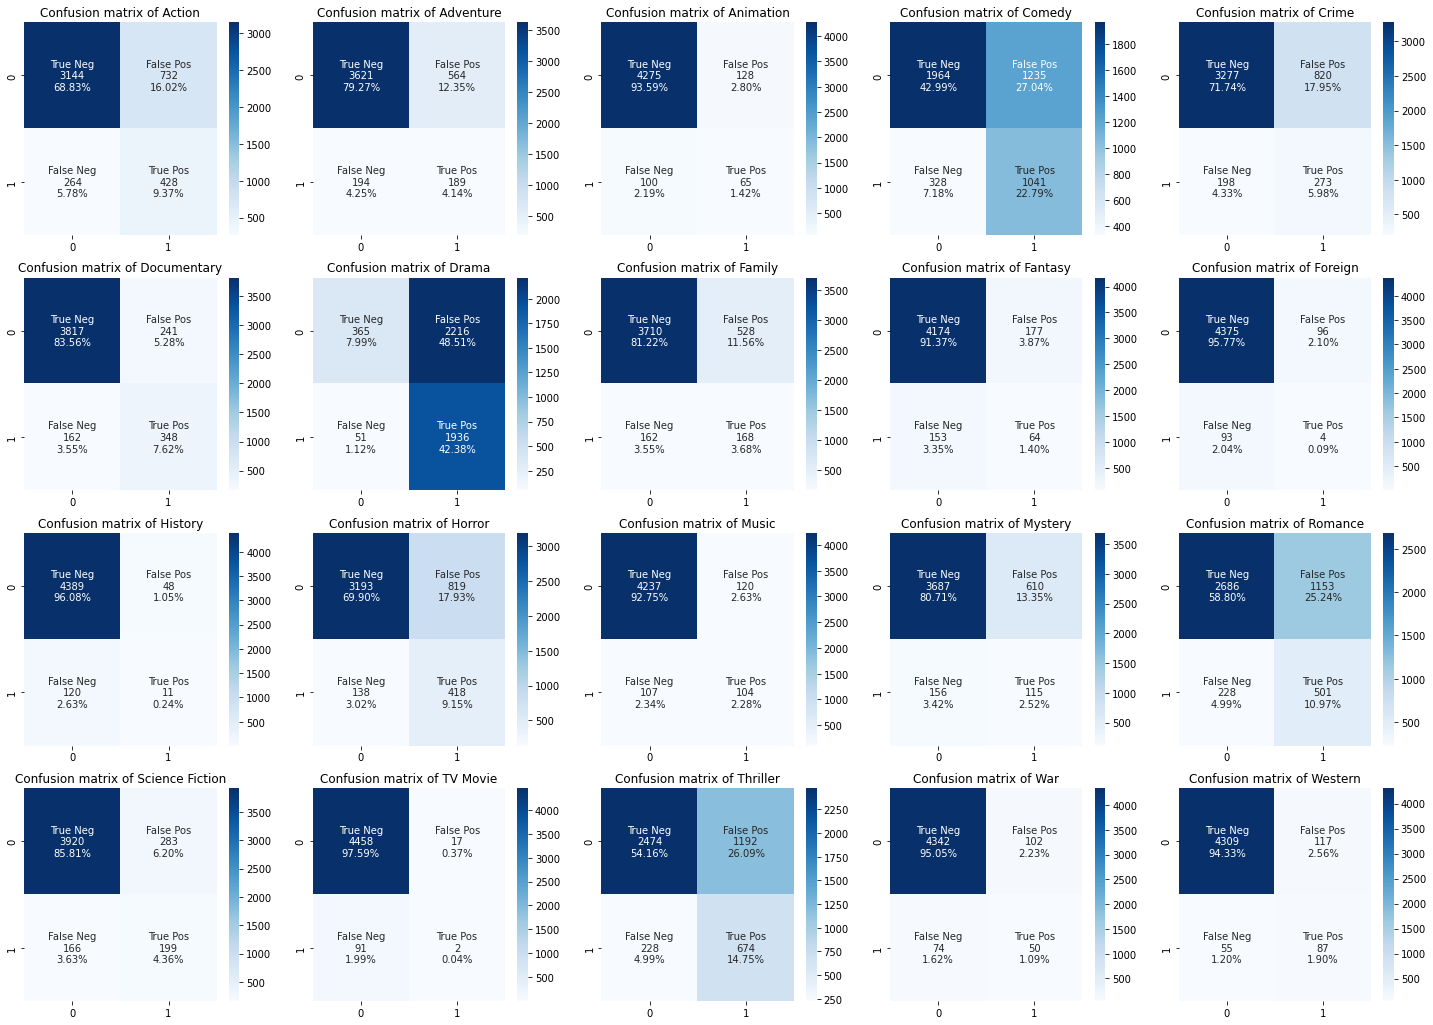

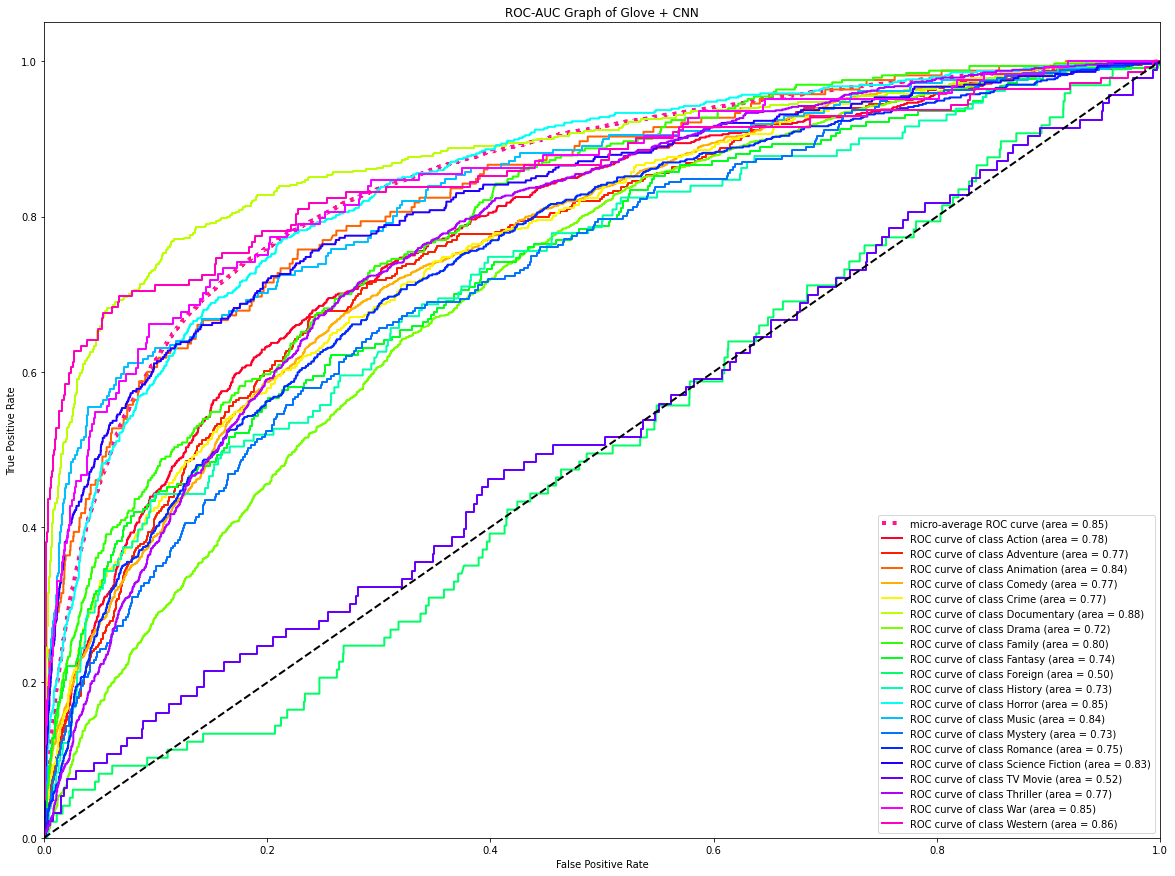

In [34]:
# Display the evaluation results
evaluate_display(model, test_loader, device, attributes, model_name)